In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
%matplotlib inline
plt.style.use('ggplot')

from src import plotting_functions
from src import models

#from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from itertools import combinations

from io import BytesIO
import boto3
s3 = boto3.client('s3')

In [10]:
df = pd.read_pickle('data/df_formodel.pkl')

In [7]:
X = df.drop(columns='injured')
y = df['injured']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697386 entries, 0 to 697385
Data columns (total 22 columns):
hour             697386 non-null float64
injured          697386 non-null float64
new_set          697386 non-null bool
age              697386 non-null float64
visit_count      697386 non-null float64
occupancy        697386 non-null float64
longevity        697386 non-null float64
num_employees    697386 non-null float64
guest            697386 non-null uint8
member           697386 non-null uint8
punch            697386 non-null uint8
mon              697386 non-null uint8
tues             697386 non-null uint8
wed              697386 non-null uint8
thurs            697386 non-null uint8
fri              697386 non-null uint8
sat              697386 non-null uint8
sun              697386 non-null uint8
visits_3         697386 non-null int64
visits_7         697386 non-null int64
visits_14        697386 non-null int64
visits_30        697386 non-null int64
dtypes: bool(1), f

### Tune Forest Model

10-fold cross validation to optimize log-loss was performed while searching the following parameters:

`parameters = {'n_estimators':[1000],`   
             `'max_depth':[1, 2, 3, 4, 5, 6],`  
             `'min_samples_split':[2, 3, 4, 5],`  
             `'n_jobs':[50]}`  

Calculations were performed on an EC2 instance with the following results: 



### Tune Boosting Model

At each boosting stage, 10-fold cross-validation has been performed while varying the tree depth. The results are stored in `data/cross_val_results.csv`, and the mean errors are plotted below.

In [9]:
gridsearch = pd.read_csv('data/cross_val_results.csv')
gridsearch.drop(columns=['Unnamed: 0'], inplace=True)
mean_ll = plotting_functions.gridsearch_means(gridsearch, 1500, [1, 2, 3], 'log_losses')
mean_auc = plotting_functions.gridsearch_means(gridsearch, 1500, [1, 2, 3], 'aucs')

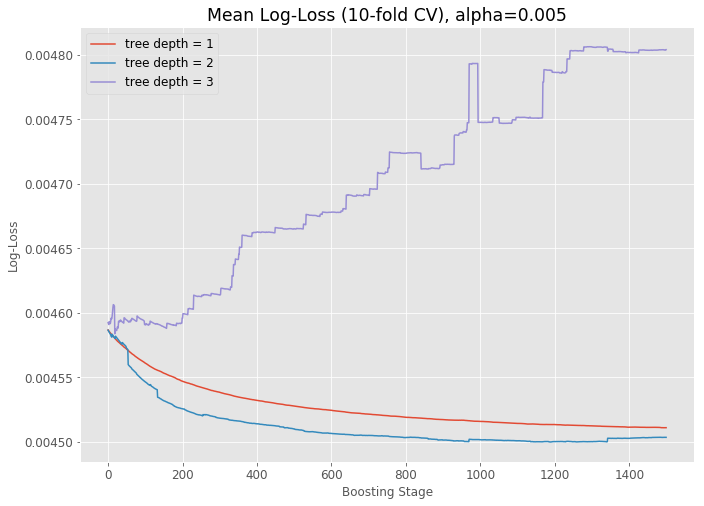

In [11]:
fig, ax = plt.subplots(figsize=(11, 8))
for i, td in enumerate([1, 2, 3]):
    ax.plot(range(1500), mean_ll[:, i], label='tree depth = {}'.format(td))
ax.legend(fontsize='large')
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)
ax.set_xlabel('Boosting Stage')
ax.set_ylabel('Log-Loss')
_=ax.set_title('Mean Log-Loss (10-fold CV), alpha=0.005', size='xx-large')
#fig.savefig('img/logloss_cv.png')

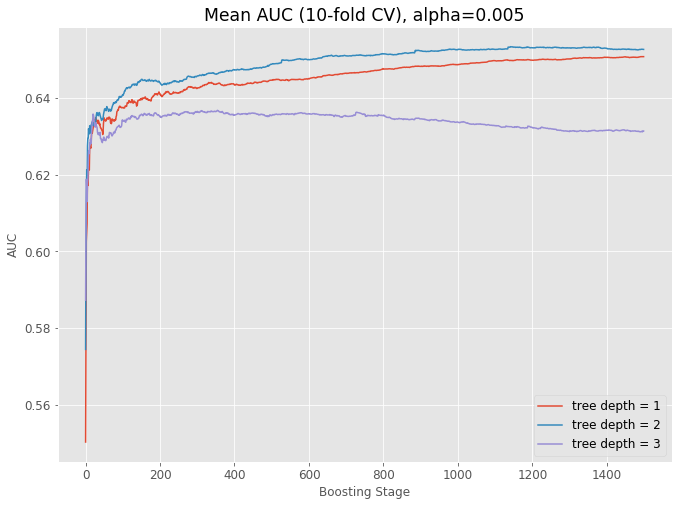

In [15]:
fig, ax = plt.subplots(figsize=(11, 8))
for i, td in enumerate([1, 2, 3]):
    ax.plot(range(1500), mean_auc[:, i], label='tree depth = {}'.format(td))
ax.legend(fontsize='large')
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)
ax.set_xlabel('Boosting Stage')
ax.set_ylabel('AUC')
_=ax.set_title('Mean AUC (10-fold CV), alpha=0.005', size='xx-large')
#fig.savefig('img/auc_cv.png')

Optimal tree_depth is 2. Optimal n_estimators is given by the minimizer of log-loss / the maximizer of AUC

In [16]:
td2_aucs = mean_auc[:,1]
td2_lls = mean_ll[:,1]
auc_maximizer = np.argmax(td2_aucs)
ll_minimizer = np.argmin(td2_lls)
print('Optimal AUC = {:0.5f} \t\t with n_estimators = {}'.format(td2_aucs[auc_maximizer], auc_maximizer))
print('Optimal log-loss = {:0.5f} \t with n_estimators = {}'.format(td2_lls[ll_minimizer], ll_minimizer))

Optimal AUC = 0.65332 		 with n_estimators = 1145
Optimal log-loss = 0.00450 	 with n_estimators = 1189


### ROC for Final Boosting & Random Forest Models

boost_outputs_df contains 50 boosted models (with randomized train/test splits) with parameters 
* max_depth : 2
* n_estimators : 1150
* learning_rate : 0.005
* subsample : 0.5  

forest_outputs_df contains 50 random forest models (with randomized train/test splits) with parameters
* max_depth : 5
* min_samples_split : 2
* n_estimators : 1000

In [3]:
# 50 boosts
pickled_data_gb = s3.get_object(Bucket='sbp-data-etc', Key='boost_outputs_df.pkl')
pickle_file_gb = BytesIO(pickled_data_gb['Body'].read())
boosting_df = pd.read_pickle(pickle_file_gb)

# 50 forests
pickled_data_rf = s3.get_object(Bucket='sbp-data-etc', Key='forest_outputs_df.pkl')
pickle_file_rf = BytesIO(pickled_data_rf['Body'].read())
forest_df = pd.read_pickle(pickle_file_rf)

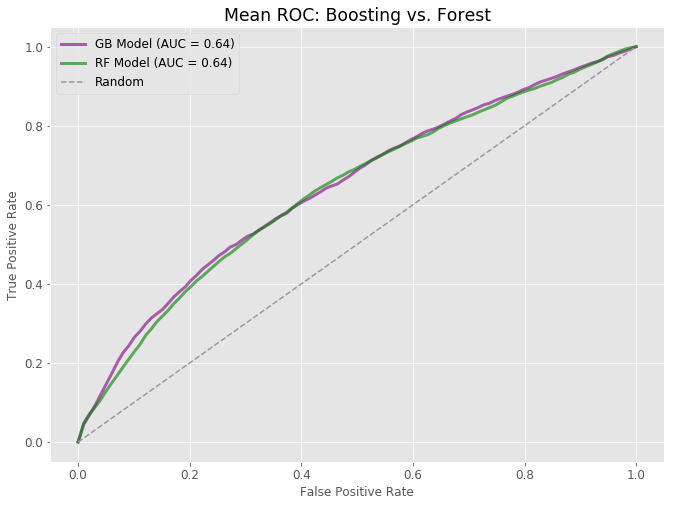

In [8]:
forest_df['y_true'] = [y.iloc[i].values for i in forest_df['indices'].values]
boosting_df['y_true'] = [y.iloc[i].values for i in boosting_df['indices'].values]

plt, fig, ax = plotting_functions.bootstrapped_roc2(boosting_df.y_true.values, 
                                 boosting_df.y_hat.values, 
                                 forest_df.y_true.values, 
                                 forest_df.y_hat.values, all_plots=False)

### Feature Importances (Random Forest)

In [12]:
final_forest_model = models.InjuryModel('RFC')
final_forest_model.fit(X, y)

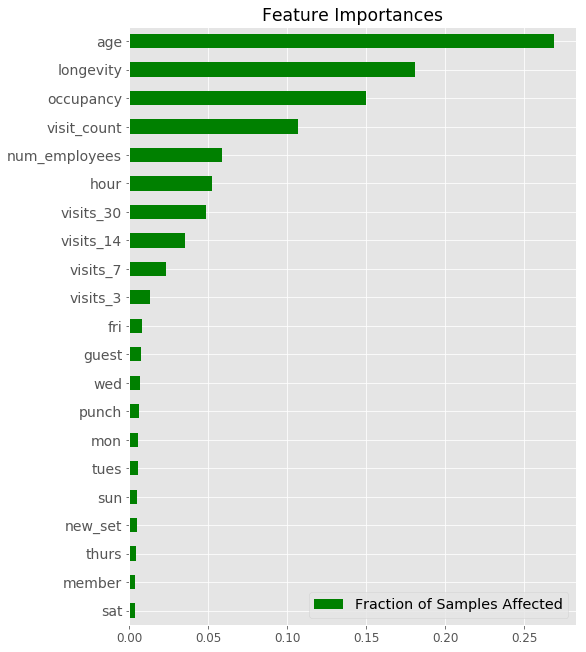

In [43]:
fig, ax = plotting_functions.plot_feat_scores(
    final_forest_model, 
    X.columns,
    filepath='img/feature_importances.png')

### Compare AUC Histograms with Features Dropped

Investigate feature importances by dropping single features from the dataset, then comparing the bootstrapped AUC distributions with and without this feature. 

The dataframe `auc_diffs` was created by running 100 bootstrapped random forest models after dropping a single column, and computing the AUC for each model. 

`auc` contains the distribution of AUC scores for the full model.  
`age` contains the distribution of AUC scores for the model with the feature `age` dropped.  
`age_diff` is the difference in AUC scores.  
And so on. 

In [20]:
auc_diffs = pd.read_pickle('data/auc_diffs.pkl')

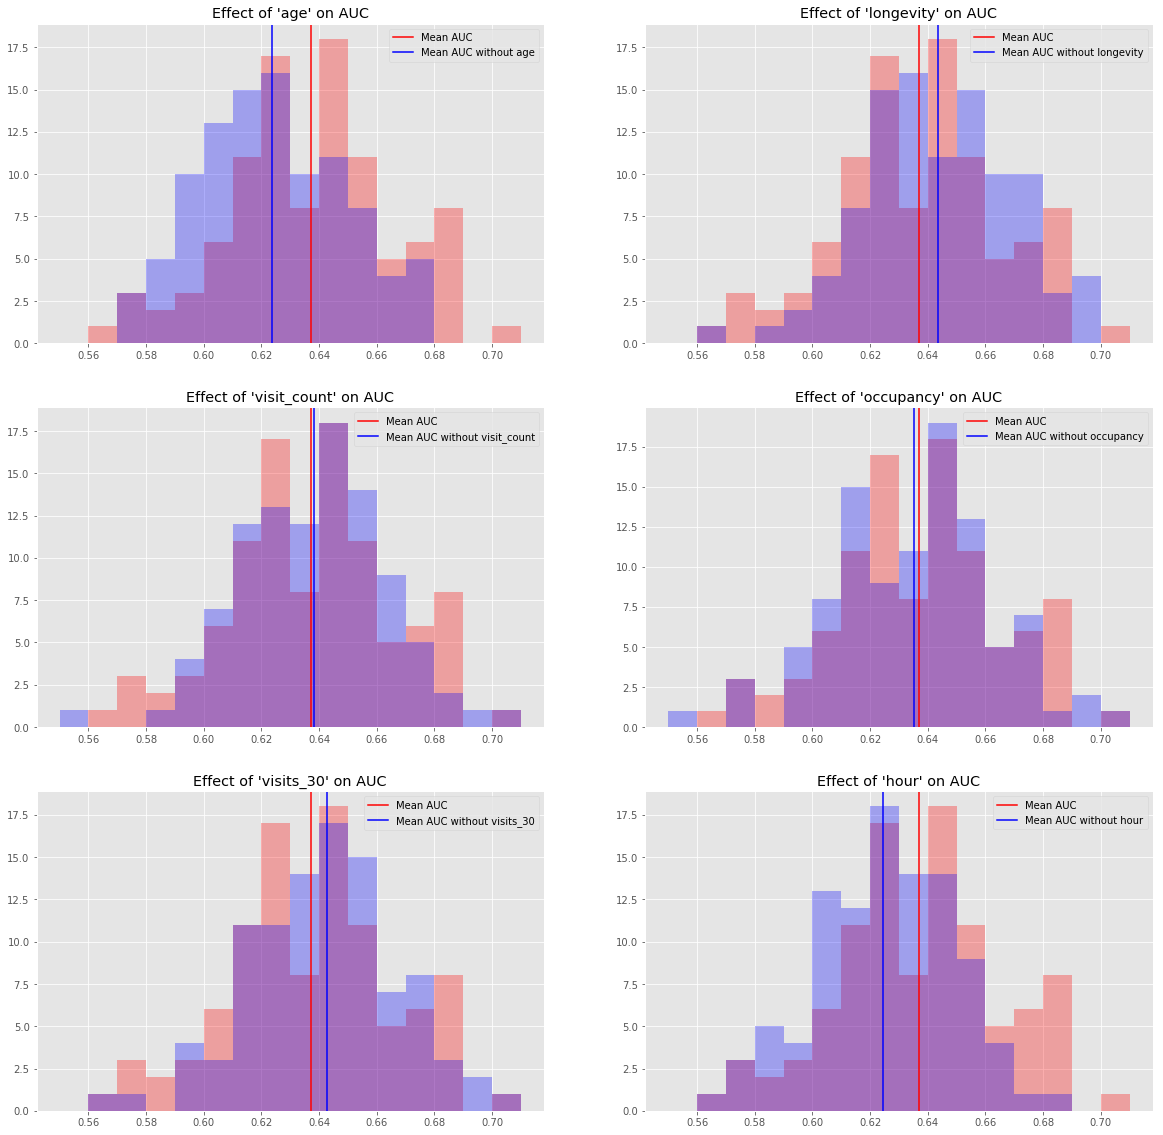

In [72]:
diff_list = ['age', 'longevity', 'visit_count', 'occupancy', 
             'visits_30', 'hour', 'member']
binarray = np.arange(0.55, 0.72, 0.01)

fig, axs = plt.subplots(3,2, figsize=[20, 20])
for feature, ax in zip(diff_list, axs.flatten()):
    auc_diffs['auc'].hist(ax=ax, bins=binarray, color='r', alpha=0.3)
    auc_diffs[feature].hist(ax=ax, bins=binarray, color='b', alpha=0.3)
    ax.axvline(np.mean(auc_diffs['auc']), color='r', label='Mean AUC')
    ax.axvline(np.mean(auc_diffs[feature]), color='b', label='Mean AUC without {}'.format(feature))
    ax.set_title("Effect of '{}' on AUC".format(feature))
    ax.legend()
#fig.savefig('img/bootstrapped_aucs.png')

### Partial Dependency Plots from Random Forest

Use 100 bootstrapped models -- this was done on an EC2 instance. See `img` folder for figures. 

### Scatter Matrix

In [22]:
df_injured = df[df['injured'] == True]
df_uninjured = df[df['injured'] == False]

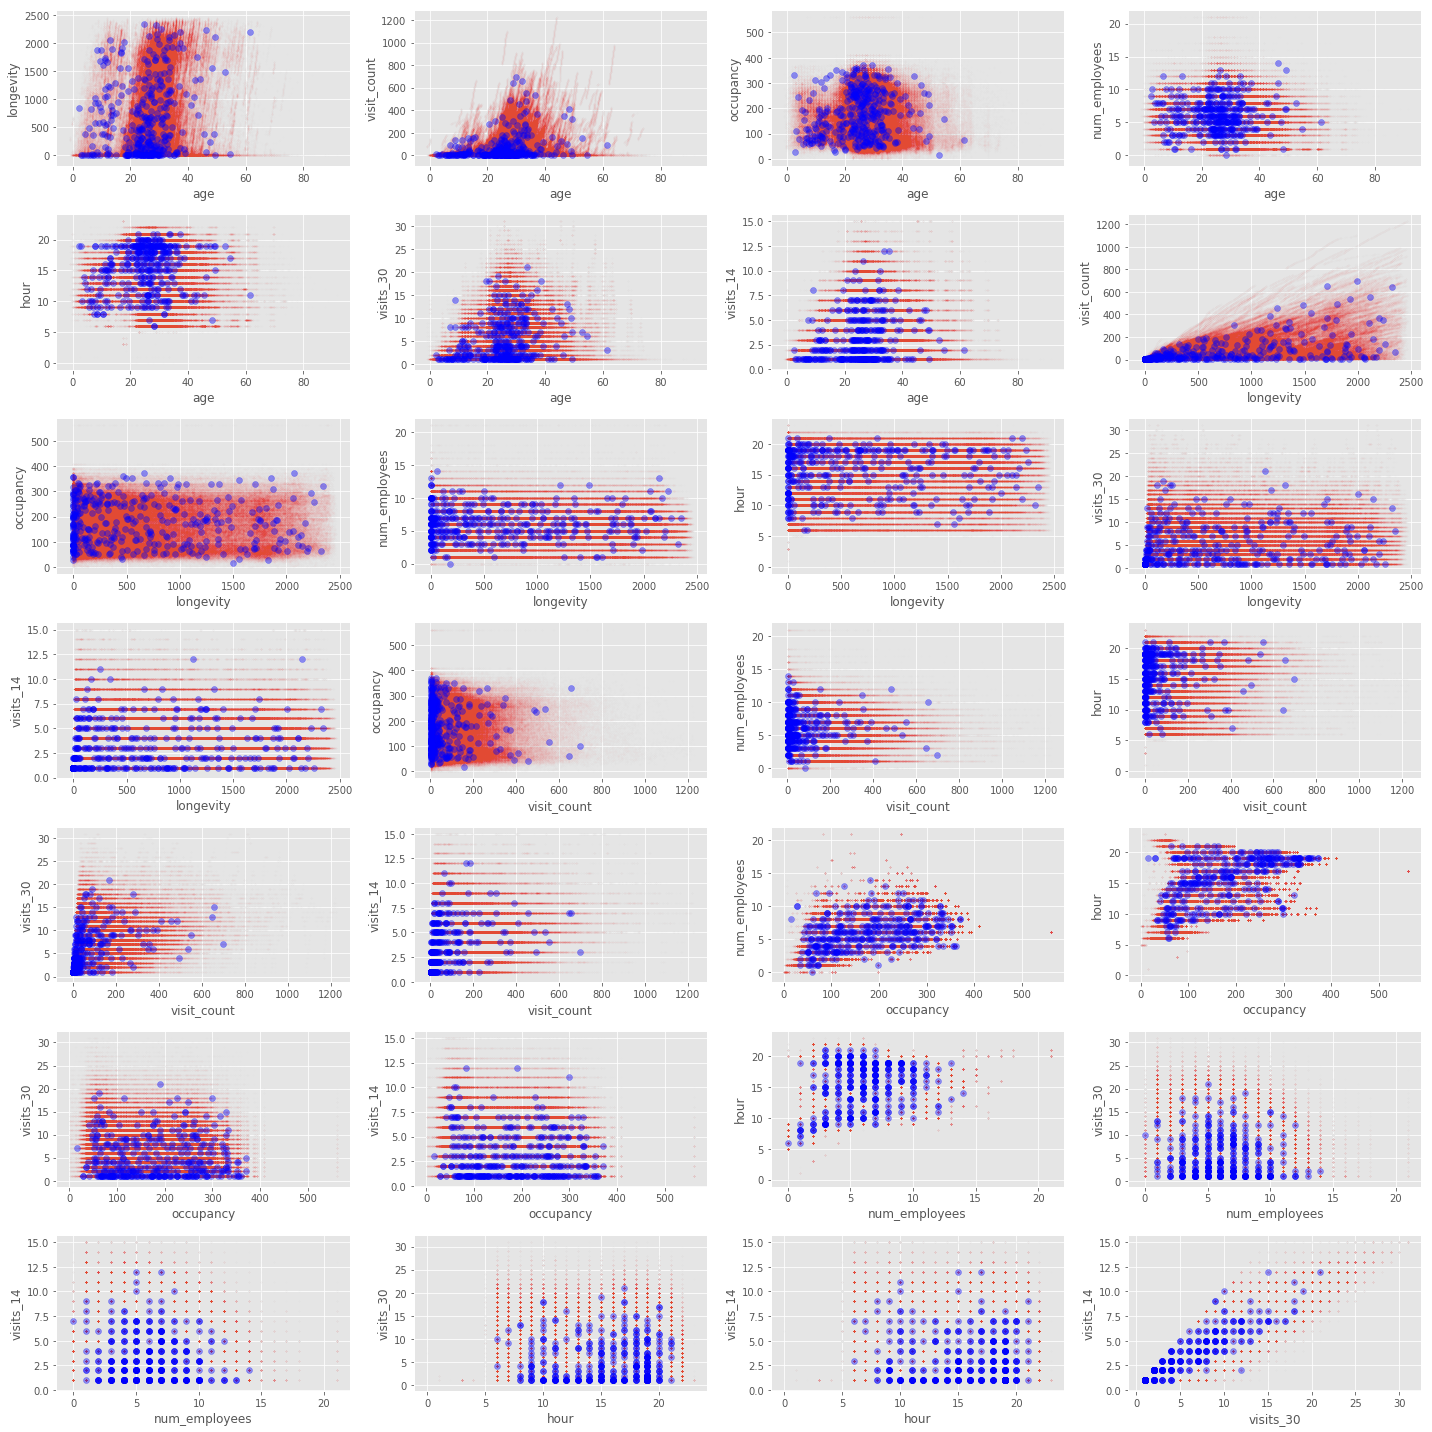

In [24]:
features = ['age', 'longevity', 'visit_count', 'occupancy', 'num_employees', 'hour',
            'visits_30', 'visits_14']
feature_pairs = combinations(features, 2)
fig, axs = plt.subplots(7, 4, figsize=[20, 20])

for pair, ax in zip(feature_pairs, axs.flatten()):
    ax.scatter(df_uninjured[pair[0]], df_uninjured[pair[1]], alpha=0.005, s=3)
    ax.scatter(df_injured[pair[0]], df_injured[pair[1]], color='b', alpha=0.4)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()
#fig.savefig('img/scatter_matrix.png')

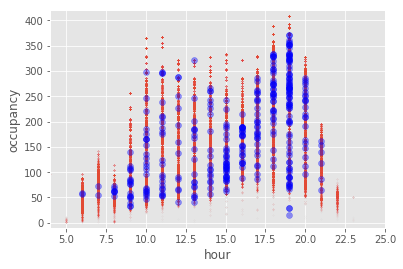

In [25]:
fig, ax = plt.subplots()
ax.scatter(df_uninjured['hour'], df_uninjured['occupancy'], alpha=0.005, s=3)
ax.scatter(df_injured['hour'], df_injured['occupancy'], color='b', alpha=0.4)
ax.set_xlabel('hour')
ax.set_ylabel('occupancy')
ax.set_xlim([4, 25])
ax.set_ylim([-10, 420])
#fig.savefig('img/scatter_hour_occ.png')

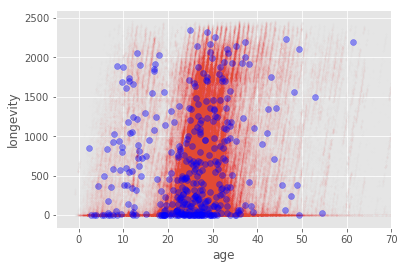

In [26]:
fig, ax = plt.subplots()
ax.scatter(df_uninjured['age'], df_uninjured['longevity'], alpha=0.005, s=3, label='uninjured')
ax.scatter(df_injured['age'], df_injured['longevity'], color='b', alpha=0.4)
ax.set_xlabel('age')
ax.set_ylabel('longevity')
ax.set_xlim([-5, 70])
#fig.savefig('img/scatter_age_long.png')

### Distribution of Predictions

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
forest_model = models.InjuryModel('RFC')
forest_model.fit(X_train.values, y_train.values)
y_hat = forest_model.predict(X_test.values)

In [45]:
y_hat = forest_model.predict(X_test)

Text(0.5,1,'Distribution of Predictions')

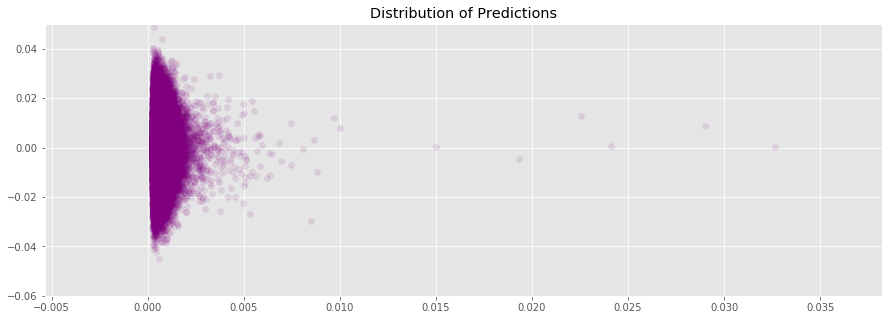

In [65]:
jitter = scs.norm.rvs(0, 0.01, size=len(y_hat))
fig, ax = plt.subplots(figsize=[15, 5])
ax.scatter(y_hat, jitter, color='purple', alpha=0.1)
ax.set_ylim([-0.06, 0.05])
ax.set_title('Distribution of Predictions')

### Explore Visit_Count

In [66]:
n_injured = len(y[y==True])
for count in range(1, 11):
    injuries = len(df[(df['visit_count'] == count) & (df['injured'] == 1)])
    print('Proportion of injuries occurring on {} vist: {:0.4f}'.format(
        count, injuries/n_injured))

Proportion of injuries occurring on 1 vist: 0.1467
Proportion of injuries occurring on 2 vist: 0.0907
Proportion of injuries occurring on 3 vist: 0.0347
Proportion of injuries occurring on 4 vist: 0.0347
Proportion of injuries occurring on 5 vist: 0.0320
Proportion of injuries occurring on 6 vist: 0.0267
Proportion of injuries occurring on 7 vist: 0.0107
Proportion of injuries occurring on 8 vist: 0.0160
Proportion of injuries occurring on 9 vist: 0.0160
Proportion of injuries occurring on 10 vist: 0.0080


In [70]:
p1 = len(df[(df['visit_count'] == 1) & (df['injured'] == 1)]) / len(df[df['visit_count'] == 1])
print('Proportion of users injured on first visit: \n{}'.format(p1))

Proportion of users injured on first visit: 
0.0009079653322327693


In [71]:
p2 = len(df[(df['visit_count'] > 1) & (df['injured'] == 1)]) / len(df[df['visit_count'] > 1])
print('Proportion of users injured after first visit: \n{}'.format(p2))

Proportion of users injured after first visit: 
0.0005025038826276556
